In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
# ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


100%|██████████| 428M/428M [00:05<00:00, 76.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.manifold import TSNE

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data'
paths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is loaded')

# dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
print(df.head())

print(df['labels'].value_counts())

Dataset is loaded
                                         audio_paths labels
0  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
1  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
2  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
3  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
4  /root/.cache/kagglehub/datasets/ejlok1/toronto...   fear
labels
fear       400
sad        400
angry      400
disgust    400
ps         400
neutral    400
happy      400
Name: count, dtype: int64


In [ ]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)


100%|██████████| 451M/451M [00:05<00:00, 89.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


In [ ]:
CREMA = '/root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/'
dir_list = os.listdir(CREMA)
dir_list.sort()

emotionG = []
gender = []
emotionO = []
path = []
female_ids = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,
              1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,1052,1053,1054,
              1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,
              1082,1084,1089,1091]

temp_dict = {"SAD":"sad", "ANG": "angry", "DIS":"disgust", "FEA":"fear",
             "HAP":"happy", "NEU":"neutral"}

def get_emotion_crema(filename, ids=female_ids, dc=temp_dict):
  filename = filename.split("_")
  emotionG1 = dc[filename[2]]
  if int(filename[0]) in ids:
    emotionG2 = "_female"
  else:
    emotionG2 = "_male"
  emotionG = emotionG1 + emotionG2
  return (emotionG, emotionG1, emotionG2[1:])


for i in dir_list:
  emotionG.append(get_emotion_crema(i)[0])
  emotionO.append(get_emotion_crema(i)[1])
  gender.append(get_emotion_crema(i)[2])
  path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotionG, columns = ['emotionG_label'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(gender, columns = ['gender'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(emotionO, columns = ['emotion'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

# Filter only emotions that match TESS
valid_emotions = ['neutral', 'sad', 'happy', 'disgust', 'fear', 'angry']
CREMA_df = CREMA_df[CREMA_df['emotion'].isin(valid_emotions)]

CREMA_df.emotionG_label.value_counts()


,count
emotionG_label,
angry_male,671
disgust_male,671
fear_male,671
happy_male,671
sad_male,671
angry_female,600
disgust_female,600
fear_female,600
happy_female,600


In [ ]:
# convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
df['labels'] = df['labels'].map(label_map)


class SpeechDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')


        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)


        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

# split into training and testing
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)




In [ ]:
class CREMADataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['emotion']

        # Load and resample audio
        speech, sr = librosa.load(audio_path, sr=16000)

        # Pad or truncate
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Tokenize
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label_map[label], dtype=torch.long)}


# Label mapping from emotions to integers (same as TESS)
label_map = {"neutral": 0, "sad": 1, "happy": 2, "disgust": 3, "fear": 4, "angry": 5}
CREMA_df['labels'] = CREMA_df['emotion'].map(label_map)
crema_train_df, crema_test_df = train_test_split(CREMA_df, test_size=0.2, random_state=42)





In [ ]:
# initialize processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)

# load data
train_dataset = SpeechDataset(train_df, processor)
test_dataset = SpeechDataset(test_df, processor)
crema_train_dataset = CREMADataset(crema_train_df, processor)
crema_test_dataset = CREMADataset(crema_test_df, processor)

# print(label_map)
# print(set(test_dataset[i]['labels'].item() for i in range(len(test_dataset))))
# print(set(train_dataset[i]['labels'].item() for i in range(len(train_dataset))))
# print(set(crema_train_dataset[i]['labels'].item() for i in range(len(crema_train_dataset))))
# print(set(crema_test_dataset[i]['labels'].item() for i in range(len(crema_test_dataset))))


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    lr_scheduler_type='cosine',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.01,
    report_to=[]
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)

    # Precision, Recall, F1 (Weighted)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Top-2 Accuracy
    top_2_preds = np.argsort(pred.predictions, axis=-1)[:, -2:]  # Get indices of top-2 predictions
    top_2_correct = np.any(top_2_preds == np.expand_dims(labels, axis=-1), axis=-1)  # Check if label is in top-2
    top_2_acc = np.mean(top_2_correct)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'top_2_accuracy': top_2_acc
    }


In [ ]:
# Pretrain on TESS
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=crema_train_dataset,  # TESS train dataset
    eval_dataset=crema_test_dataset,   # TESS test dataset
    compute_metrics=compute_metrics,  # Metric function
)

trainer.train()  # Pretrain on TESS

# Evaluate on CREMA
results = trainer.evaluate()
print(results)


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Top 2 Accuracy
1,1.749000,1.362165,0.512424,0.464245,0.511884,0.512424,0.723976
2,1.398000,1.110520,0.614506,0.593501,0.649090,0.614506,0.811283
3,1.022900,0.978221,0.661518,0.654711,0.687255,0.661518,0.856951
4,0.901800,0.913824,0.706514,0.700464,0.710546,0.706514,0.868368
5,0.762000,0.875680,0.717260,0.713160,0.720206,0.717260,0.879785


{'eval_loss': 0.8756804466247559, 'eval_accuracy': 0.7172599059771659, 'eval_f1': 0.7131596268588164, 'eval_precision': 0.7202061411993643, 'eval_recall': 0.7172599059771659, 'eval_top_2_accuracy': 0.8797850906648758, 'eval_runtime': 14.9867, 'eval_samples_per_second': 99.355, 'eval_steps_per_second': 12.478, 'epoch': 5.0}


In [ ]:
# model.save_pretrained("./saved_model")# how to load the model for later use
# processor.save_pretrained("./saved_model")


# model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
# model.load_state_dict(torch.load('teacher_model.pt'))
# model.eval()


torch.save(model.state_dict(), 'teacher_model.pt')



In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu" # you should use a GPU for this task, otherwise it will be very slow

def extract_features(model, processor, dataset, output_dir, split_name, num_layers=13, num_features=768):
    model.to(device)

    #initialize hidden states tensor to avoid itereative concatenation which is very slow
    hidden_states = torch.zeros((len(dataset), num_layers, num_features))

    # iterate over the dataset
    for i, example in enumerate(tqdm(dataset, desc=f"Extracting {split_name} features")):
        #preprocess the data, check your data how to call your audio file (here it is ["audio"]["array"])
        inputs = example['input_values'].unsqueeze(0).to(device)  # Use dataset class structure

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # average the hidden states over the time axis for each layer j
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        #optional saving after 100 steps
        # depending on the size of your dataset this process can time out so better save intermediate results
        if i > 0 and i % 100 == 0:
            intermediate_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
            np.save(intermediate_path, hidden_states.cpu().numpy())
            # print(f"Saved intermediate features for {split_name}: {intermediate_path}")

    final_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    np.save(final_path, hidden_states.cpu().numpy())
    print(f"Saved final features for {split_name}: {final_path}")



In [ ]:
output_dir = "./hidden_features"
os.makedirs(output_dir, exist_ok=True)

print("Extracting model hidden features")
extract_features(model, processor, train_dataset, output_dir, "train")
extract_features(model, processor, test_dataset, output_dir, "test")

Extracting model hidden features


Extracting train features: 100%|██████████| 2240/2240 [00:49<00:00, 44.83it/s]


Saved final features for train: ./hidden_features/train_hidden_states.npy


Extracting test features: 100%|██████████| 560/560 [00:11<00:00, 48.65it/s]

Saved final features for test: ./hidden_features/test_hidden_states.npy


In [ ]:
# provided code:
import torch
from sklearn.metrics.pairwise import linear_kernel
import numpy as np


### TAKEN FROM HERE: https://github.com/minyoungg/platonic-rep/blob/main/metrics.py

## mutual KNN
def compute_nearest_neighbors(feats, topk=1):
    """
    Compute the nearest neighbors of feats
    Args:
        feats: a torch tensor of shape N x D
        topk: the number of nearest neighbors to return
    Returns:
        knn: a torch tensor of shape N x topk
    """
    assert feats.ndim == 2, f"Expected feats to be 2D, got {feats.ndim}"
    knn = (
        (feats @ feats.T).fill_diagonal_(-1e8).argsort(dim=1, descending=True)[:, :topk]
    )
    return knn

def mutual_knn(feats_A, feats_B, topk):
    """
    Computes the mutual KNN accuracy.

    Args:
        feats_A: A torch tensor of shape N x feat_dim
        feats_B: A torch tensor of shape N x feat_dim

    Returns:
        A float representing the mutual KNN accuracy
    """
    knn_A = compute_nearest_neighbors(feats_A, topk)
    knn_B = compute_nearest_neighbors(feats_B, topk)

    n = knn_A.shape[0]
    topk = knn_A.shape[1]

    # Create a range tensor for indexing
    range_tensor = torch.arange(n, device=knn_A.device).unsqueeze(1)

    # Create binary masks for knn_A and knn_B
    lvm_mask = torch.zeros(n, n, device=knn_A.device)
    llm_mask = torch.zeros(n, n, device=knn_A.device)

    lvm_mask[range_tensor, knn_A] = 1.0
    llm_mask[range_tensor, knn_B] = 1.0

    acc = (lvm_mask * llm_mask).sum(dim=1) / topk

    return acc.mean().item()


## CKA
def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]

    # Zero out the diagonal elements of K and L
    K_tilde = K.clone().fill_diagonal_(0)
    L_tilde = L.clone().fill_diagonal_(0)

    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (torch.sum(K_tilde * L_tilde.T))
        + (torch.sum(K_tilde) * torch.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * torch.sum(torch.mm(K_tilde, L_tilde)) / (m - 2))
    )

    HSIC_value /= m * (m - 3)
    return HSIC_value


def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = torch.eye(K.shape[0], dtype=K.dtype, device=K.device) - 1 / K.shape[0]
    return torch.trace(K @ H @ L @ H)

def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
        """Computes the unbiased Centered Kernel Alignment (CKA) between features."""

        if kernel_metric == 'ip':
            # Compute kernel matrices for the linear case
            K = torch.mm(feats_A, feats_A.T)
            L = torch.mm(feats_B, feats_B.T)
        elif kernel_metric == 'rbf':
            # COMPUTES RBF KERNEL
            K = torch.exp(-torch.cdist(feats_A, feats_A) ** 2 / (2 * rbf_sigma ** 2))
            L = torch.exp(-torch.cdist(feats_B, feats_B) ** 2 / (2 * rbf_sigma ** 2))
        else:
            raise ValueError(f"Invalid kernel metric {kernel_metric}")

        # Compute HSIC values
        hsic_fn = hsic_unbiased if unbiased else hsic_biased
        hsic_kk = hsic_fn(K, K)
        hsic_ll = hsic_fn(L, L)
        hsic_kl = hsic_fn(K, L)

        # Compute CKA
        #print('hsic', hsic_kl)
        cka_value = hsic_kl / (torch.sqrt(hsic_kk * hsic_ll) + 1e-6)
        return cka_value.item()


def cosine_similarity(feats_A, feats_B):
    """
    Compute the cosine similarity between two sets of features.
    Args:
        feats_A: a torch tensor of shape N x D
        feats_B: a torch tensor of shape N x D
    Returns:
        a torch tensor of shape N x N
    """
    assert feats_A.ndim == 2, f"Expected feats_A to be 2D, got {feats_A.ndim}"
    assert feats_B.ndim == 2, f"Expected feats_B to be 2D, got {feats_B.ndim}"
    feats_A = feats_A / torch.norm(feats_A, dim=1, keepdim=True)
    feats_B = feats_B / torch.norm(feats_B, dim=1, keepdim=True)
    return feats_A @ feats_B.T

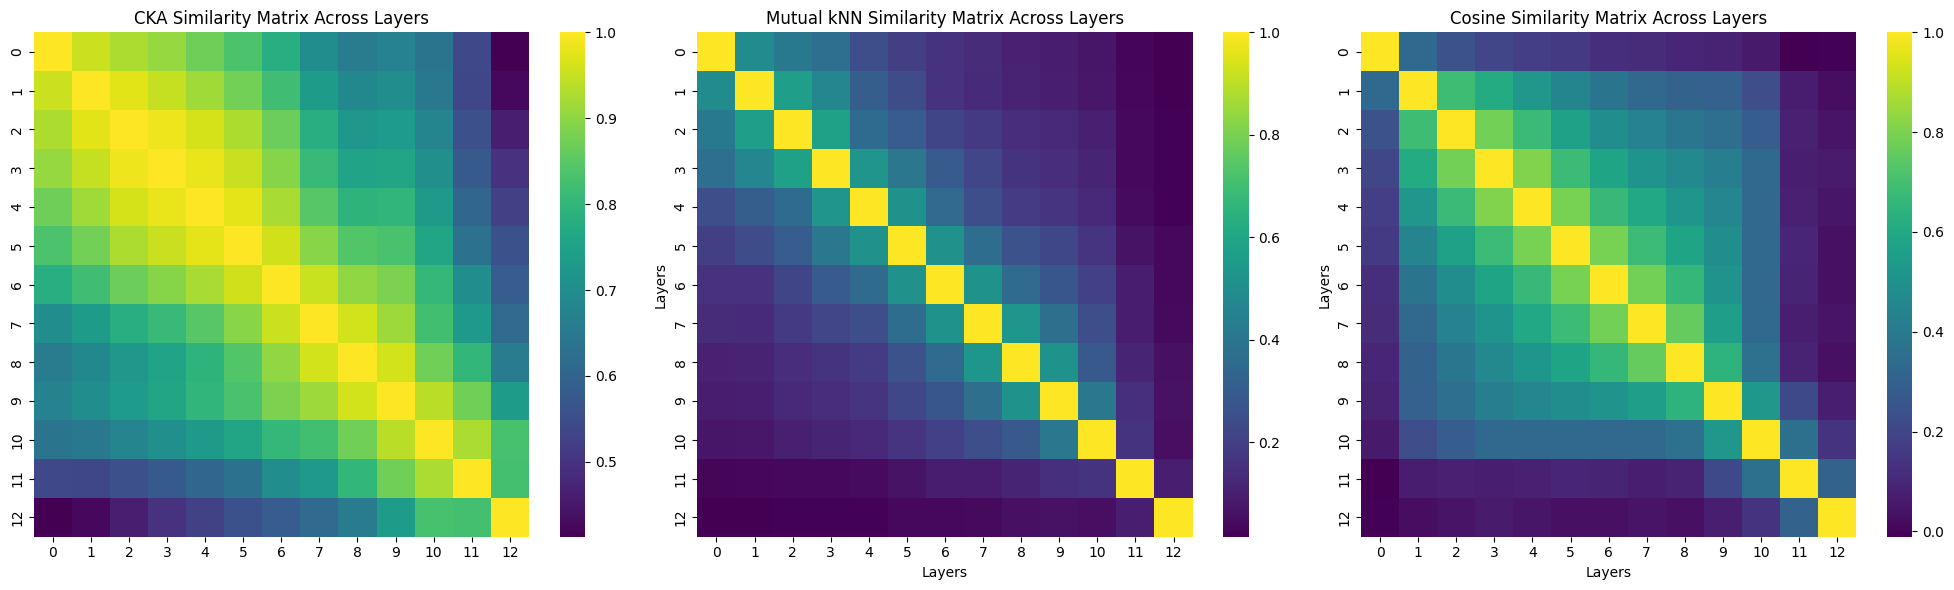

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("hidden_features/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

In [ ]:
import os
import torch
import numpy as np
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Load the teacher model
teacher_model_path = "teacher_model.pt"
teacher_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.to(device)
teacher_model.eval()

# Load processor (if needed)
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model_accuracy(model, dataset, device='cuda'):
    """
    Evaluates the accuracy and top-2 accuracy of a given model on a provided dataset.

    Parameters:
    - model: The model to evaluate.
    - dataset: The dataset containing input features and labels.
    - device: The device to run the evaluation on ('cuda' or 'cpu').

    Returns:
    - accuracy: The accuracy of the model on the dataset.
    - top2_accuracy: The top-2 accuracy of the model on the dataset.
    """
    model.eval()
    predictions, true_labels = [], []
    top2_correct = 0

    # Iterate through the dataset
    with torch.no_grad():
        for i in range(len(dataset)):
            batch = dataset[i]

            # Load data into the device
            inputs = batch['input_values'].unsqueeze(0).to(device)  # Add batch dimension
            labels = batch['labels'].to(device)

            # Perform forward pass
            logits = model(inputs).logits

            # Get predictions
            top_preds = torch.topk(logits, k=2, dim=-1).indices.cpu().numpy()  # Top-2 predictions
            preds = torch.argmax(logits, dim=-1).cpu().numpy()  # Top-1 prediction

            # Check if the true label is in the top-2 predictions
            true_label = labels.cpu().item()
            if true_label in top_preds[0]:
                top2_correct += 1

            # Collect top-1 predictions and labels
            predictions.extend(preds)
            true_labels.append(true_label)

    # Calculate accuracies
    accuracy = accuracy_score(true_labels, predictions)
    top2_accuracy = top2_correct / len(dataset)

    return accuracy, top2_accuracy


# Function to measure inference time
def measure_inference_time(model, dataset, sample_idx=0, device='cuda'):
    """
    Measures the inference time for a single sample in the dataset.

    Parameters:
    - model: The model to evaluate.
    - dataset: The dataset containing input features and labels.
    - sample_idx: The index of the sample to measure inference time on.
    - device: The device to run the inference on ('cuda' or 'cpu').

    Returns:
    - inference_time: Time taken for the model to process the sample.
    """
    sample_input = dataset[sample_idx]['input_values'].unsqueeze(0).to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model(sample_input)
    end_time = time.time()
    return end_time - start_time


In [ ]:
# Function to calculate BI scores using the test dataset
def calculate_bi_scores_with_dataset(model, dataset):
    original_accuracy = evaluate_model_accuracy(model, dataset)
    bi_scores = []

    for layer_idx in range(len(model.wav2vec2.encoder.layers)):
        # Bypass layer with metadata compatibility
        def bypass_layer(hidden_states, attention_mask=None, *args, **kwargs):
            if attention_mask is not None:
                attention_mask = attention_mask.clone()
            return hidden_states.clone(), attention_mask

        original_forward = model.wav2vec2.encoder.layers[layer_idx].forward
        model.wav2vec2.encoder.layers[layer_idx].forward = bypass_layer

        try:
            pruned_accuracy = evaluate_model_accuracy(model, dataset)
        except (RuntimeError, ValueError) as e:
            print(f"Error bypassing layer {layer_idx}: {e}")
            pruned_accuracy = original_accuracy

        bi_scores.append(original_accuracy - pruned_accuracy)
        print(f"Layer {layer_idx}: BI Score = {bi_scores[-1]}")

        model.wav2vec2.encoder.layers[layer_idx].forward = original_forward

    return bi_scores


In [ ]:
# Calculate BI scores
bi_scores = calculate_bi_scores_with_dataset(teacher_model, crema_test_dataset)
print("BI Scores:", bi_scores)


In [ ]:
import copy
import numpy as np
import torch

def prune_model_with_cka(model, bi_scores, cka_matrix, bi_threshold=0.02, cka_threshold=0.85):
    layers_to_prune = []
    for idx, bi_score in enumerate(bi_scores):
        cka_similarity = np.mean(cka_matrix[idx, :])
        print(f"Layer {idx}: BI Score = {bi_score}, CKA Similarity = {cka_similarity}")

        # Prune layer if it meets both conditions
        if bi_score < bi_threshold or cka_similarity > cka_threshold:
            layers_to_prune.append(idx)

    print(f"Layers to prune based on criteria: {layers_to_prune}")

    # Remove layers from the model
    pruned_model = copy.deepcopy(model)
    pruned_model.wav2vec2.encoder.layers = torch.nn.ModuleList([
        layer for i, layer in enumerate(pruned_model.wav2vec2.encoder.layers) if i not in layers_to_prune
    ])
    return pruned_model, layers_to_prune


In [ ]:
# Prune the model
pruned_model, pruned_layers = prune_model_with_cka(teacher_model, bi_scores, cka_matrix)
print(f"Pruned Layers: {pruned_layers}")


In [ ]:
# pruned_model.save_pretrained("./pruned_model")# how to load the model for later use

In [ ]:
# Reload the teacher model to its original state after BI score calculations
teacher_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
teacher_model.load_state_dict(torch.load("teacher_model.pt"))
teacher_model.to(device)
teacher_model.eval()

# Compare model sizes
teacher_model_size = os.path.getsize(teacher_model_path) / (1024 ** 2)  # Size in MB
pruned_model_size = sum(p.element_size() * p.numel() for p in pruned_model.parameters()) / (1024 ** 2)

# Measure inference times
teacher_inference_time = measure_inference_time(teacher_model, crema_test_dataset)
pruned_inference_time = measure_inference_time(pruned_model, crema_test_dataset)

# Evaluate accuracies

# Evaluate Teacher Model Accuracy
teacher_accuracy = evaluate_model_accuracy(teacher_model, crema_test_dataset, device='cuda')

# Evaluate Pruned Model Accuracy
pruned_accuracy = evaluate_model_accuracy(pruned_model, crema_test_dataset, device='cuda')

# Print comparison metrics
print(f"Teacher Model Size: {teacher_model_size:.2f} MB")
print(f"Pruned Model Size: {pruned_model_size:.2f} MB")
print(f"Teacher Model Inference Time: {teacher_inference_time:.4f} seconds")
print(f"Pruned Model Inference Time: {pruned_inference_time:.4f} seconds")
print(f"Teacher Model Accuracy: {teacher_accuracy:.4f}")
print(f"Pruned Model Accuracy: {pruned_accuracy:.4f}")


In [ ]:
output_dir = "./pruned_features"
os.makedirs(output_dir, exist_ok=True)

print("Extracting model hidden features")
extract_features(pruned_model, processor, train_dataset, output_dir, "train")
extract_features(pruned_model, processor, test_dataset, output_dir, "test")

Extracting model hidden features


Extracting train features: 100%|██████████| 2240/2240 [00:46<00:00, 48.67it/s]


Saved final features for train: ./pruned_features/train_hidden_states.npy


Extracting test features: 100%|██████████| 560/560 [00:09<00:00, 59.04it/s]

Saved final features for test: ./pruned_features/test_hidden_states.npy


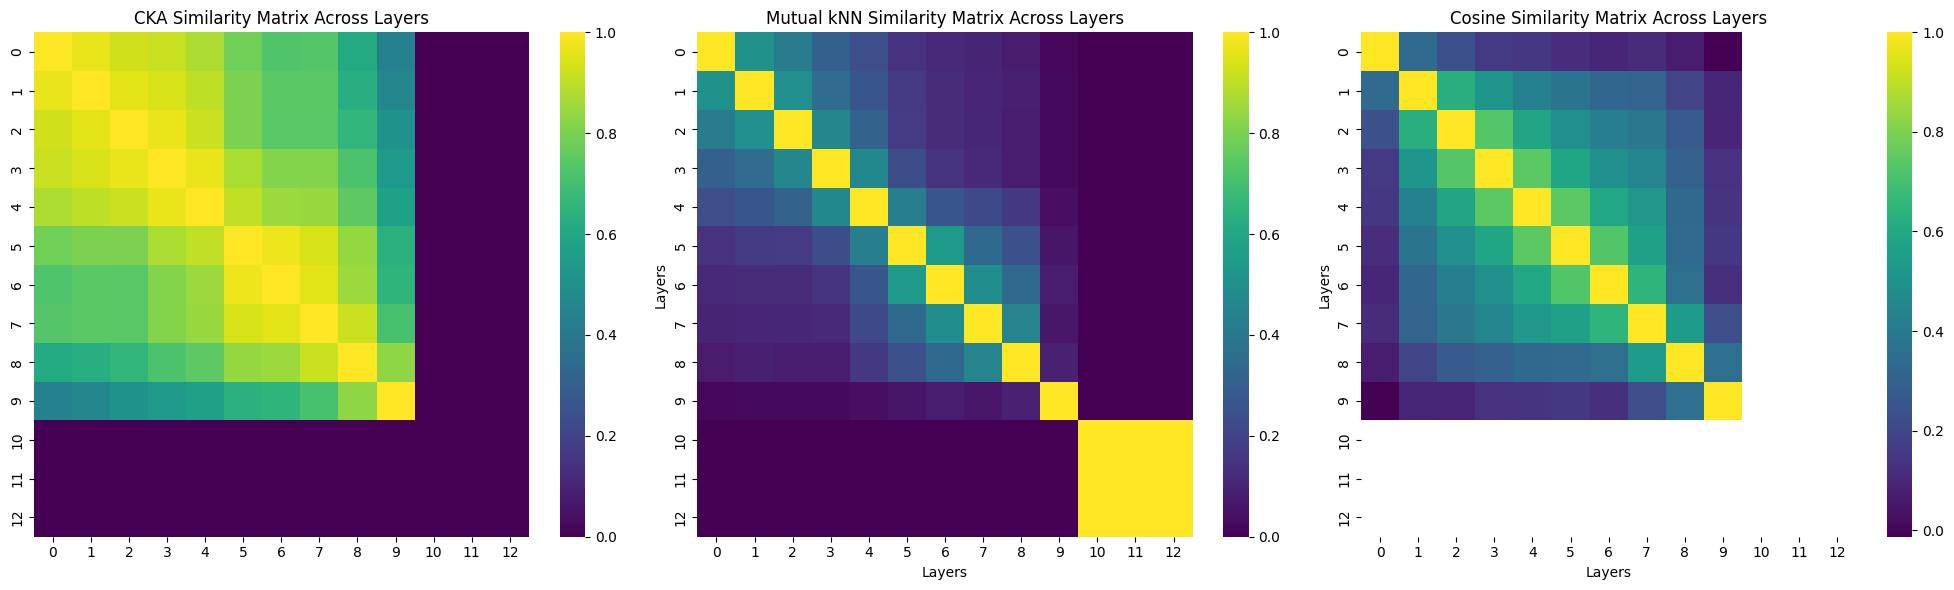

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("pruned_features/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

In [ ]:
# Define Student model
from transformers import Wav2Vec2Config, Wav2Vec2ForSequenceClassification

# Define student model configuration
student_config = Wav2Vec2Config(
    hidden_size=512,  # Reduce hidden size
    num_hidden_layers=8,  # Fewer transformer layers
    num_attention_heads=4,  # Fewer attention heads
    num_labels=7  # Match the number of output labels
)

# Initialize student model
student_model = Wav2Vec2ForSequenceClassification(student_config)
student_model.to('cuda')  # Move to GPU if available


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)


In [ ]:
# define KD loss function
import torch.nn.functional as F

def kd_loss(student_logits, teacher_logits, labels, temperature, alpha):
    # Soft targets from teacher
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
    student_probs = F.log_softmax(student_logits / temperature, dim=-1)
    soft_loss = F.kl_div(student_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)

    # Hard targets (ground truth)
    hard_loss = F.cross_entropy(student_logits, labels)

    # Combine losses
    return alpha * soft_loss + (1 - alpha) * hard_loss


In [ ]:
# train student
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch

# Optimizer for student model
optimizer = AdamW(student_model.parameters(), lr=5e-5, weight_decay=0.01)

# Training parameters
num_epochs = 20
temperature = 5.0
alpha = 0.7

teacher_model.to('cuda')
student_model.to('cuda')

# Dataloader for batched training
train_loader = DataLoader(crema_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(crema_test_dataset, batch_size=16, shuffle=False)

for epoch in range(num_epochs):
    # Training phase
    student_model.train()
    total_loss = 0

    for batch in train_loader:
        inputs = batch['input_values'].to('cuda')  # Batch inputs
        labels = batch['labels'].to('cuda')  # Batch labels

        # Teacher forward pass
        with torch.no_grad():
            teacher_logits = teacher_model(inputs).logits

        # Student forward pass
        student_logits = student_model(inputs).logits

        # Compute KD loss
        loss = kd_loss(student_logits, teacher_logits, labels, temperature, alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Evaluation phase
    student_model.eval()
    predictions, true_labels = [], []
    top2_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_values'].to('cuda')
            labels = batch['labels'].to('cuda')

            logits = student_model(inputs).logits

            # Top-1 predictions
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())

            # Top-2 predictions
            top2_preds = torch.topk(logits, 2, dim=-1).indices
            top2_predictions.extend(top2_preds.cpu().numpy())

            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and top-2 accuracy
    accuracy = accuracy_score(true_labels, predictions)
    top2_accuracy = sum(
        [true_labels[i] in top2_predictions[i] for i in range(len(true_labels))]
    ) / len(true_labels)

    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}, Top-2 Accuracy: {top2_accuracy:.4f}")


Epoch 1/20, Training Loss: 0.9113
Epoch 1/20, Test Accuracy: 0.3700, Top-2 Accuracy: 0.5944
Epoch 2/20, Training Loss: 0.8364
Epoch 2/20, Test Accuracy: 0.4392, Top-2 Accuracy: 0.6709
Epoch 3/20, Training Loss: 0.8056
Epoch 3/20, Test Accuracy: 0.4547, Top-2 Accuracy: 0.6877
Epoch 4/20, Training Loss: 0.7764
Epoch 4/20, Test Accuracy: 0.4406, Top-2 Accuracy: 0.6944
Epoch 5/20, Training Loss: 0.7411
Epoch 5/20, Test Accuracy: 0.4815, Top-2 Accuracy: 0.7105
Epoch 6/20, Training Loss: 0.7032
Epoch 6/20, Test Accuracy: 0.4936, Top-2 Accuracy: 0.7092
Epoch 7/20, Training Loss: 0.6702
Epoch 7/20, Test Accuracy: 0.4997, Top-2 Accuracy: 0.7139
Epoch 8/20, Training Loss: 0.6074
Epoch 8/20, Test Accuracy: 0.5064, Top-2 Accuracy: 0.7085
Epoch 9/20, Training Loss: 0.5644
Epoch 9/20, Test Accuracy: 0.4876, Top-2 Accuracy: 0.7052
Epoch 10/20, Training Loss: 0.5158
Epoch 10/20, Test Accuracy: 0.4741, Top-2 Accuracy: 0.7025
Epoch 11/20, Training Loss: 0.4782
Epoch 11/20, Test Accuracy: 0.4788, Top-2 A

In [ ]:
# Student Teacher Comparison

import os
import time

teacher_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
teacher_model.load_state_dict(torch.load("teacher_model.pt"))
teacher_model.to(device)
teacher_model.eval()

# Compare model size
# teacher_model_size = os.path.getsize('/content/drive/MyDrive/Emotion Recognition Model/teacher_model.pt') / (1024 ** 2)  # Size in MB
student_model_size = os.path.getsize('student_model.pt') / (1024 ** 2)  # Size in MB
# print(f"Teacher Model Size: {teacher_model_size:.2f} MB")
# print(f"Student Model Size: {student_model_size:.2f} MB")

# Compare inference time
def measure_inference_time(model, inputs):
    start_time = time.time()
    with torch.no_grad():
        _ = model(inputs)
    end_time = time.time()
    return end_time - start_time

batch = crema_test_dataset[0]['input_values'].unsqueeze(0).to('cuda')  # Single input
teacher_time = measure_inference_time(teacher_model, batch)
student_time = measure_inference_time(student_model, batch)

print(f"Teacher Inference Time: {teacher_time:.4f} seconds")
print(f"Student Inference Time: {student_time:.4f} seconds")

# Compare accuracy
def evaluate_model(model, dataset):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for i in range(len(dataset)):
            batch = dataset[i]
            inputs = batch['input_values'].unsqueeze(0).to('cuda')
            labels = batch['labels'].unsqueeze(0).to('cuda')

            logits = model(inputs).logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# teacher_model.load_state_dict(torch.load('teacher_model.pt'))
teacher_model.eval()
teacher_acc = evaluate_model(teacher_model, crema_test_dataset)
student_acc = evaluate_model(student_model, crema_test_dataset)

print(f"Teacher Accuracy: {teacher_acc:.4f}")
print(f"Student Accuracy: {student_acc:.4f}")



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Teacher Inference Time: 0.0099 seconds
Student Inference Time: 0.0081 seconds
Teacher Accuracy: 0.7005
Student Accuracy: 0.5057


In [ ]:
torch.save(student_model.state_dict(), 'student_model.pt')


In [ ]:
# Feature Extraction on student model
# slightly altered feature extraction code for student model
def extract_features(model, processor, dataset, output_dir, split_name):
    model.to(device)

    # Dynamically infer hidden size and number of layers
    hidden_size = model.config.hidden_size
    num_layers = model.config.num_hidden_layers + 1  # Add 1 for the input layer's hidden state

    # Initialize hidden states tensor
    hidden_states = torch.zeros((len(dataset), num_layers, hidden_size)).to(device)

    # Iterate over the dataset
    for i, example in enumerate(tqdm(dataset, desc=f"Extracting {split_name} features")):
        inputs = example['input_values'].unsqueeze(0).to(device)  # Use dataset class structure

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # Average the hidden states over the time axis for each layer
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        # Save intermediate results every 100 steps
        if i > 0 and i % 100 == 0:
            intermediate_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
            np.save(intermediate_path, hidden_states.cpu().numpy())
            # print(f"Saved intermediate features for {split_name}: {intermediate_path}")

    # Save the final features
    final_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    np.save(final_path, hidden_states.cpu().numpy())
    print(f"Saved final features for {split_name}: {final_path}")

# Extract features for the student model
print("Extracting student model hidden features")
output_dir = "./student_hidden_features"
os.makedirs(output_dir, exist_ok=True)

# Train and test feature extraction
extract_features(student_model, processor, train_dataset, output_dir, "train")
extract_features(student_model, processor, test_dataset, output_dir, "test")


Extracting student model hidden features


Extracting train features: 100%|██████████| 2240/2240 [00:30<00:00, 73.40it/s]


Saved final features for train: ./student_hidden_features/train_hidden_states.npy


Extracting test features: 100%|██████████| 560/560 [00:08<00:00, 69.56it/s]

Saved final features for test: ./student_hidden_features/test_hidden_states.npy


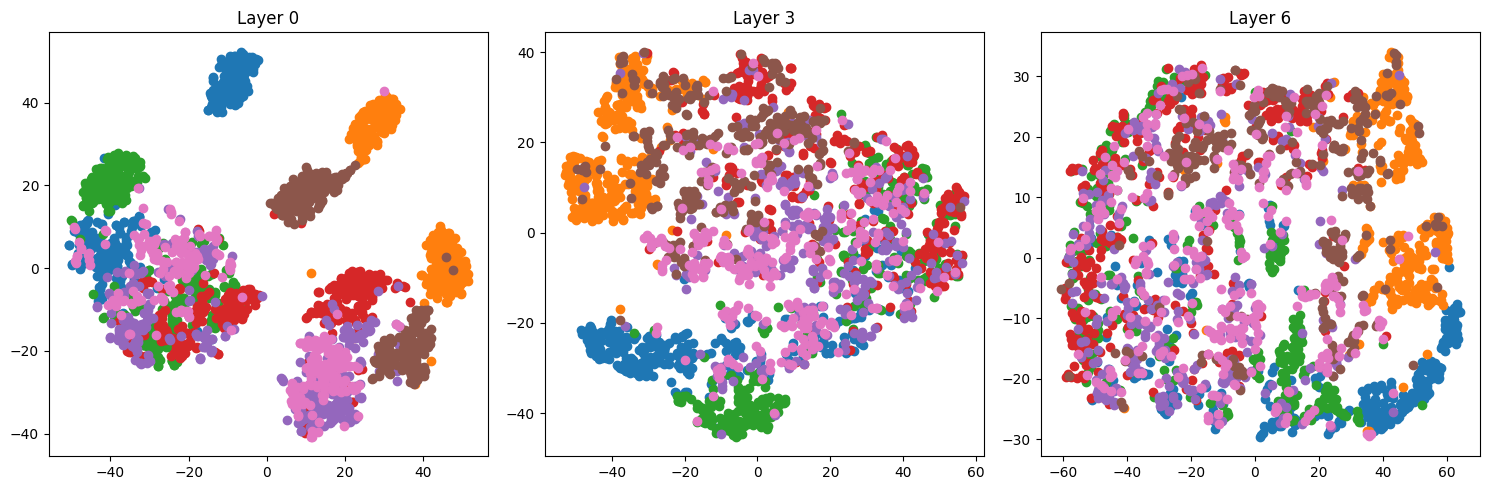

In [ ]:
# visualize extracted features
hidden_states = np.load("student_hidden_features/train_hidden_states.npy")
labels = np.array(train_df['labels'])
unique_labels = np.unique(labels)

# visualize the hidden states using tsne of a few layers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, layer in enumerate([0, 3, 6]):
    X_embedded = TSNE().fit_transform(hidden_states[:, layer, :])
    ax = axes[idx]
    for i in range(len(unique_labels)):
        ax.scatter(X_embedded[labels == unique_labels[i], 0], X_embedded[labels == unique_labels[i], 1], marker='o')
    ax.set_title(f"Layer {layer}")

plt.tight_layout()
plt.show()

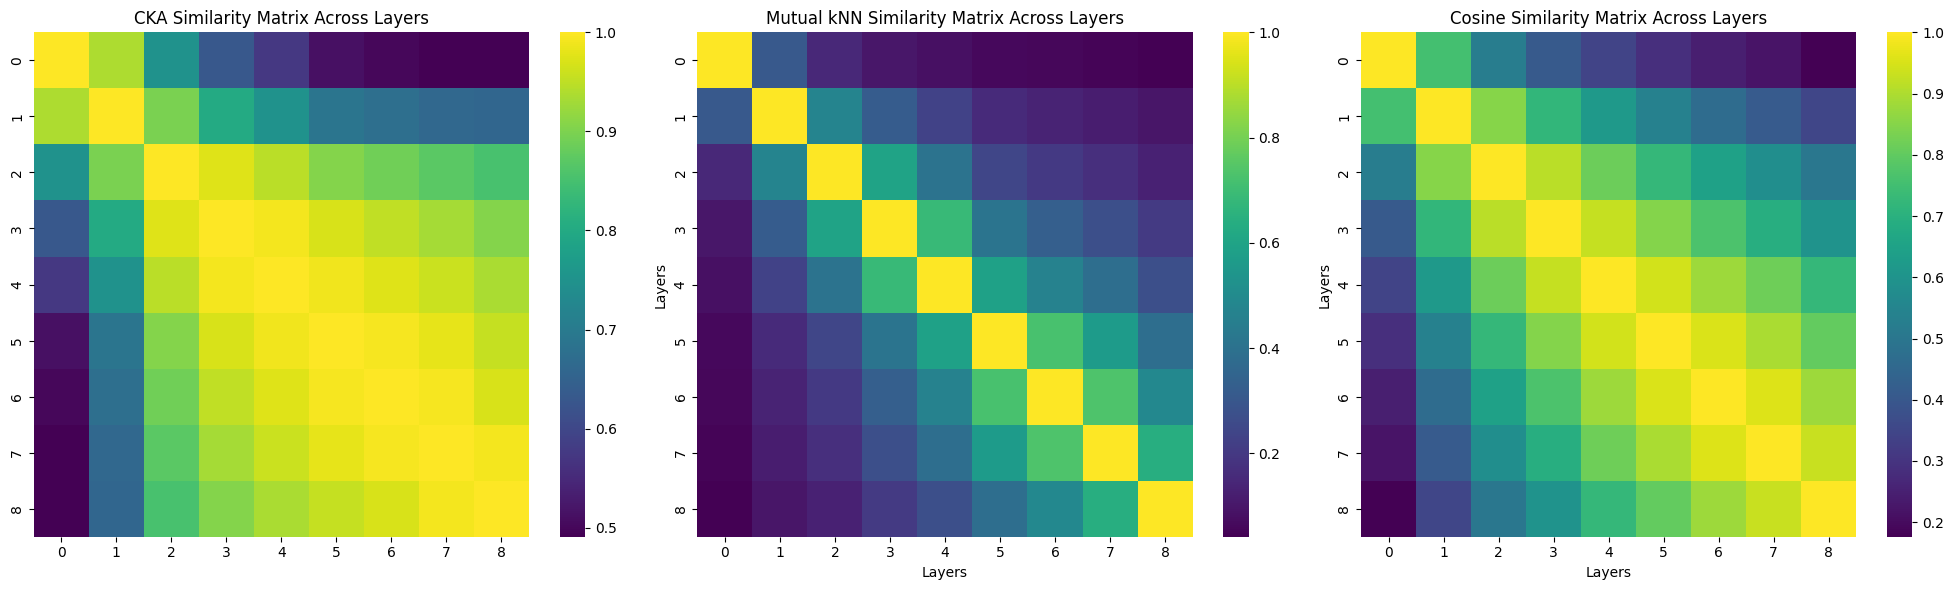

In [ ]:
# similarity on student model
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("student_hidden_features/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()